In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from utils import plot_hist_per_columns, plot_scatter_per_columns, plot_box_per_columns, shapiro_wilk_test, outliers_detection, jarque_bera_test, QQPlot, log_transform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [72]:
train_data = "../data/train.csv"
test_data = "../data/test.csv"
df_train = pd.read_csv(train_data)

y = df_train.SalePrice

## Exploración

In [ ]:
missing_perc = df_train.isna().mean() * 100
missing_selected = missing_perc[missing_perc > 40]

missing_selected = missing_selected.apply(lambda x: "% " + str(round(x, 2)))

if (missing_perc > 0).any():
    print(missing_selected)
else:
    print("No missing values")

print()

if (df_train.duplicated().any()):
    print("Data has duplicated values.")
else:
    print("Data has no duplicated values.")


Alley          % 93.77
MasVnrType     % 59.73
FireplaceQu    % 47.26
PoolQC         % 99.52
Fence          % 80.75
MiscFeature     % 96.3
dtype: object

Data has no duplicated values.


In [74]:
porch_cols = [col for col in df_train.columns if "porch" in col.lower()]
print(*porch_cols, sep="\n")

OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch


(<Figure size 1500x500 with 4 Axes>,
 array([<Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'EnclosedPorch'}>,
        <Axes: title={'center': '3SsnPorch'}>,
        <Axes: title={'center': 'ScreenPorch'}>], dtype=object))

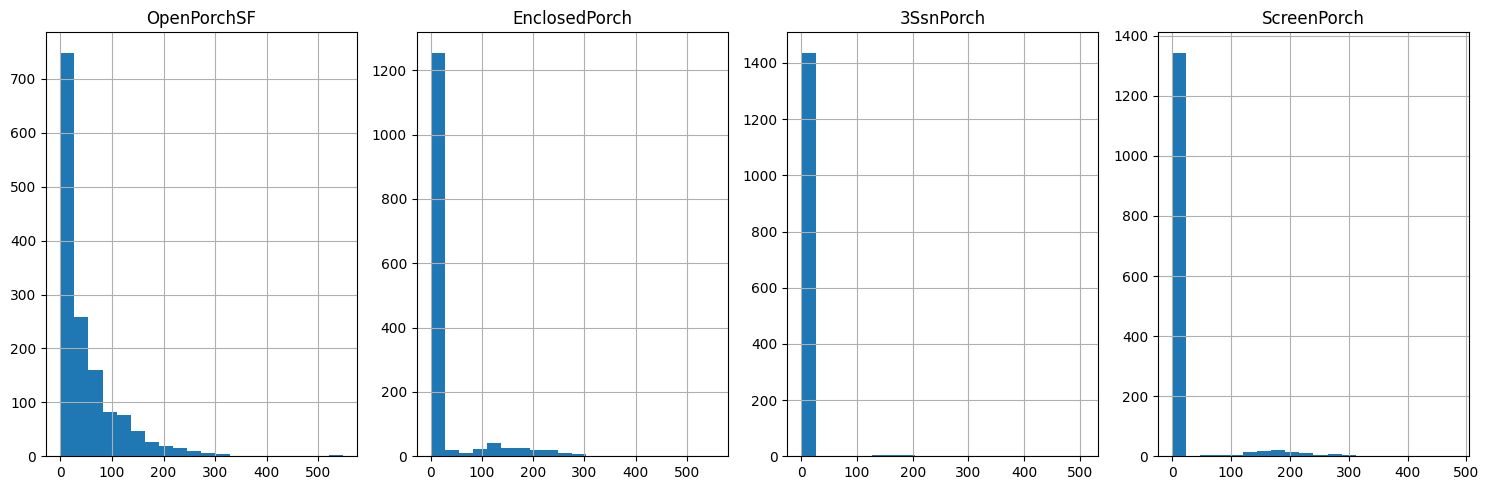

In [75]:
plot_hist_per_columns(df_train, porch_cols)

(<Figure size 1500x500 with 4 Axes>,
 array([<Axes: title={'center': 'OpenPorchSF'}>,
        <Axes: title={'center': 'EnclosedPorch'}>,
        <Axes: title={'center': '3SsnPorch'}>,
        <Axes: title={'center': 'ScreenPorch'}>], dtype=object))

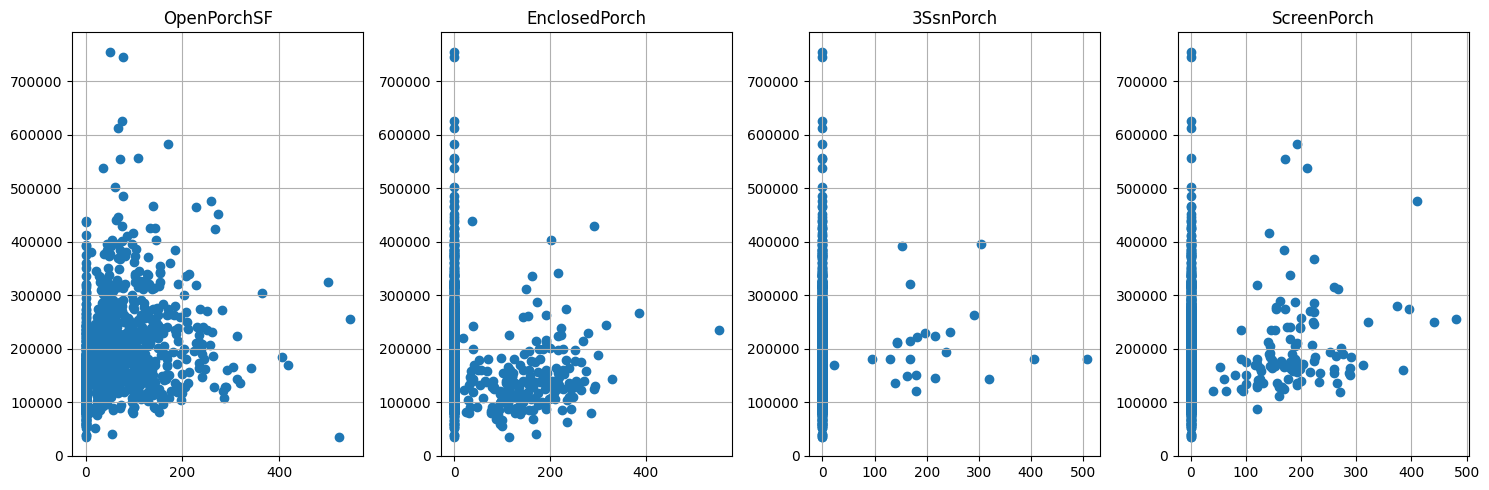

In [76]:
plot_scatter_per_columns(df_train, porch_cols)

In [77]:
df_train_2 = df_train.drop(porch_cols[1:], axis=1)
df_train_2.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [78]:
df_train_2_numerics = df_train_2.select_dtypes(include=np.number).drop(columns=['MSSubClass'])
corr = df_train_2_numerics.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))
corr

SalePrice       1.00000
OverallQual     0.79098
GrLivArea       0.70862
GarageCars      0.64041
GarageArea      0.62343
TotalBsmtSF     0.61358
1stFlrSF        0.60585
FullBath        0.56066
TotRmsAbvGrd    0.53372
YearBuilt       0.52290
YearRemodAdd    0.50710
GarageYrBlt     0.48636
MasVnrArea      0.47749
Fireplaces      0.46693
BsmtFinSF1      0.38642
LotFrontage     0.35180
WoodDeckSF      0.32441
2ndFlrSF        0.31933
OpenPorchSF     0.31586
HalfBath        0.28411
LotArea         0.26384
BsmtFullBath    0.22712
BsmtUnfSF       0.21448
BedroomAbvGr    0.16821
PoolArea        0.09240
MoSold          0.04643
BsmtFinSF2     -0.01138
BsmtHalfBath   -0.01684
MiscVal        -0.02119
Id             -0.02192
LowQualFinSF   -0.02561
YrSold         -0.02892
OverallCond    -0.07786
KitchenAbvGr   -0.13591
Name: SalePrice, dtype: float64

### Analisis Variables Normales

In [79]:
vanilla_normal_cols = []
for col in df_train_2_numerics.columns:
    if jarque_bera_test(df_train_2_numerics[col], print_results = False):
        vanilla_normal_cols.append(col)
print(*vanilla_normal_cols, sep="\n")

In [80]:
df_train_vanilla_normals = df_train_2_numerics[vanilla_normal_cols + ["SalePrice"]]
df_train_vanilla_normals.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))

SalePrice    1.0
Name: SalePrice, dtype: float64

In [81]:
white_list = [
    'Id',
    'MSSubClass',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
]

for col in df_train_2_numerics.columns:
    if col in white_list:
        continue
    outliers = outliers_detection(df_train_2_numerics[col])
    if outliers is not None and len(outliers) > 0:
        print(col, outliers)
        df_train_2_numerics[col] = df_train_2_numerics[col].replace(outliers, np.nan)
print("Outliers found and replaced.")

LotFrontage [7]
LotArea [53]
OverallQual [58]
OverallCond [1]
YearBuilt [106]
MasVnrArea [25]
BsmtFinSF1 [53]
BsmtFinSF2 [0]
BsmtUnfSF [22]
TotalBsmtSF [17]
1stFlrSF [66]
2ndFlrSF [691]
LowQualFinSF [0]
GrLivArea [58]
BsmtFullBath [738]
BsmtHalfBath [0]
BedroomAbvGr [53]
Fireplaces [166]
GarageYrBlt [39]
GarageCars [420]
GarageArea [178]
WoodDeckSF [53]
OpenPorchSF [7]
PoolArea [0]
MiscVal [0]
SalePrice [11]
Outliers found and replaced.


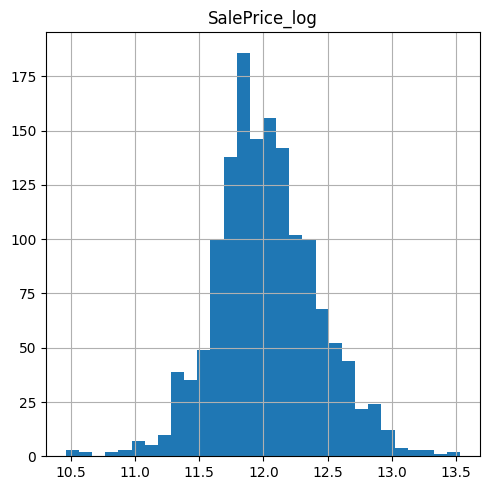

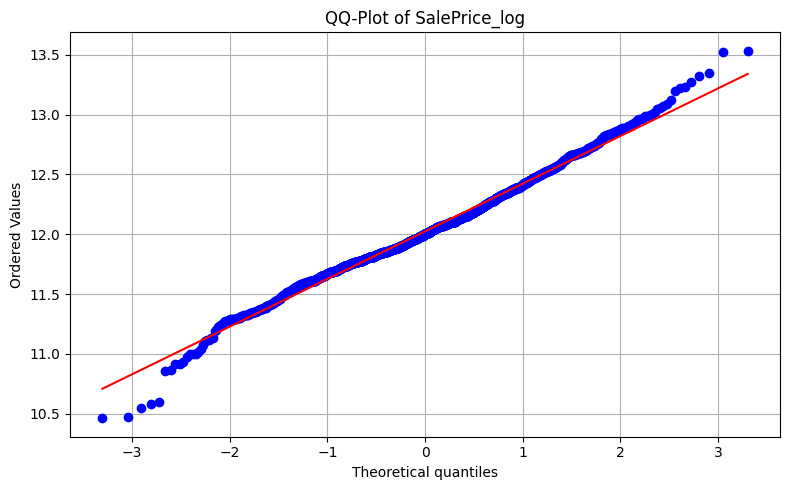

In [82]:
y_logs = log_transform(df_train_2_numerics["SalePrice"])
df_train_2_numerics["SalePrice_log"] = y_logs

plot_hist_per_columns(df_train_2_numerics, 'SalePrice_log', bins=30)
QQPlot(df_train_2_numerics["SalePrice_log"])

In [83]:
df_train_2_numerics

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_log
0,1,65.0,8450,7,5.0,2003,2003,196.0,706,NaN,...,2,548,0.0,61,NaN,NaN,2,2008,208500,12.247694
1,2,80.0,9600,6,8.0,1976,1976,0.0,978,NaN,...,2,460,298.0,0,NaN,NaN,5,2007,181500,12.109011
2,3,68.0,11250,7,5.0,2001,2002,162.0,486,NaN,...,2,608,0.0,42,NaN,NaN,9,2008,223500,12.317167
3,4,60.0,9550,7,5.0,1915,1970,0.0,216,NaN,...,3,642,0.0,35,NaN,NaN,2,2006,140000,11.849398
4,5,84.0,14260,8,5.0,2000,2000,350.0,655,NaN,...,3,836,192.0,84,NaN,NaN,12,2008,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,6,5.0,1999,2000,0.0,0,NaN,...,2,460,0.0,40,NaN,NaN,8,2007,175000,12.072541
1456,1457,85.0,13175,6,6.0,1978,1988,119.0,790,163.0,...,2,500,349.0,0,NaN,NaN,2,2010,210000,12.254863
1457,1458,66.0,9042,7,9.0,1941,2006,0.0,275,NaN,...,1,252,0.0,60,NaN,2500.0,5,2010,266500,12.493130
1458,1459,68.0,9717,5,6.0,1950,1996,0.0,49,1029.0,...,1,240,366.0,0,NaN,NaN,4,2010,142125,11.864462


In [84]:
keep_corr = df_train_2_numerics.drop(["SalePrice"], axis=1).corr()['SalePrice_log'].sort_values(ascending=False).apply(lambda x: round(x, 5)).drop(["SalePrice_log"])

corr_significant = keep_corr[np.abs(keep_corr) > 0.5]
corr_significant

OverallQual     0.81718
GrLivArea       0.70093
GarageCars      0.68062
GarageArea      0.65089
TotalBsmtSF     0.61213
1stFlrSF        0.59698
FullBath        0.59477
YearBuilt       0.58657
YearRemodAdd    0.56561
GarageYrBlt     0.54107
TotRmsAbvGrd    0.53442
Name: SalePrice_log, dtype: float64

In [85]:
df_train_2_numerics['Year_Age'] = df_train_2_numerics['YearBuilt'] - df_train_2_numerics['YearRemodAdd']

In [86]:
from sklearn.metrics import r2_score

df_train_2_numerics.fillna(df_train_2_numerics.mean(), inplace=True)
X = df_train_2_numerics.drop(["SalePrice", "SalePrice_log"], axis=1)
y = df_train_2_numerics["SalePrice_log"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))  

Mean squared error: 0.02
Root mean squared error: 0.15
Coefficient of determination: 0.88


In [87]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.02
Root mean squared error: 0.15
Coefficient of determination: 0.88


In [88]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.02
Root mean squared error: 0.15
Coefficient of determination: 0.88


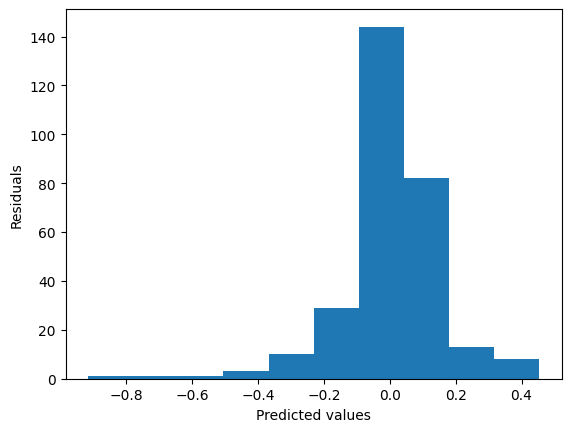

Jarque_Bera test stadistic: 691.8065
p-value: 0.0000000000
Data is not normal.


False

In [97]:
# check residuals

residuals = y_test  - y_pred

plt.hist(residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()
jarque_bera_test(residuals)

In [ ]:

df_test = pd.read_csv(test_data)
df_test_numerics = df_test.select_dtypes(include=['int64', 'float64'])


df_test_numerics.fillna(df_test_numerics.mean(), inplace=True)
X_test = df_test_numerics
X_test = X_test.reindex(columns=X.columns, fill_value=0)

y_pred_test = rf.predict(X_test)
y_pred_exp = np.exp(y_pred_test)

(array([ 3.,  9., 39., 80., 62., 43., 25., 20.,  9.,  2.]),
 array([11.01659428, 11.23321446, 11.44983464, 11.66645482, 11.88307499,
        12.09969517, 12.31631535, 12.53293553, 12.74955571, 12.96617589,
        13.18279606]),
 <BarContainer object of 10 artists>)

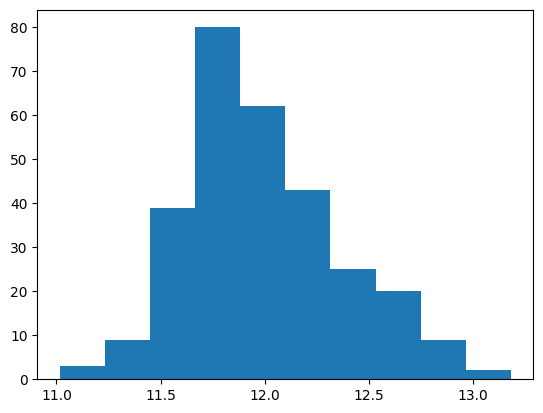

In [91]:
# hist y_pred_exp

plt.hist(y_pred)